In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import statsmodels.graphics.api as smg
from statsmodels.graphics.tsaplots import plot_pacf
import pandas as pd
import random
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa import stattools as st
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import os
import math
import pandas as pd
from sklearn import preprocessing

In [2]:
def load_data():
    df = pd.read_csv( os.path.join('csv_label', 'learning_data_10.csv') )
    return df[df['day']<=1]

In [3]:
def make_data(x, str,w):
    x=pd.DataFrame(x)
    window=w
    for i in range(1, window):
        column=f'{str}_lag{i}'
        x[column]=x[str].shift(i)
    
#     for i in range(-1, -window, -1):
#         column=f'{str}_lag{i}'
#         x[column]=x[str].shift(i)   
    return x

In [4]:
df= load_data()
# 正規化
# df['original']=preprocessing.minmax_scale(df[['original']])
# df

In [5]:
lag=[] 
window=6
for str in ['original']:
    lag.append(make_data(df[str], str, window))

# lag.append(df['trend'])
# lag.append(df['seasonal'])
# lag.append(df['resid'])
lag.append(df['day'])
lag.append(df['label'])
df_add_lag=pd.concat(lag, axis=1)
df=df_add_lag.dropna().reset_index(drop=True)
df

,original,original_lag1,original_lag2,original_lag3,original_lag4,original_lag5,day,label
0,54.0,53.6,53.2,52.8,52.8,53.4,0,0
1,54.7,54.0,53.6,53.2,52.8,52.8,0,0
2,55.7,54.7,54.0,53.6,53.2,52.8,0,0
3,55.5,55.7,54.7,54.0,53.6,53.2,0,0
4,55.7,55.5,55.7,54.7,54.0,53.6,0,0
...,...,...,...,...,...,...,...,...
719460,46.0,46.1,45.9,45.7,45.6,46.0,1,0
719461,46.0,46.0,46.1,45.9,45.7,45.6,1,0
719462,45.9,46.0,46.0,46.1,45.9,45.7,1,0
719463,45.9,45.9,46.0,46.0,46.1,45.9,1,0


In [6]:
X_train=df[(df['label']==0)&(df['day']==0)][df.columns[1:-2]].values
# X_train=df[(df['day']==0)][df.columns[1:-2]].values
X_test=df[(df['day']!=0)][df.columns[1:-2]].values

y_train=df[(df['label']==0)&(df['day']==0)][df.columns[0]].values
# y_train=df[(df['day']==0)][df.columns[0]].values
y_test=df[(df['day']!=0)][df.columns[0]].values

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
r_forest = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                     max_depth=10, random_state=0, loss='ls')
r_forest.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=10, random_state=0)

In [8]:
tr_start=0
tr_end=tr_start+len(X_train)-1
z_train_pred = np.array(r_forest.predict(X_train))
z_train=pd.DataFrame(z_train_pred, index=range(tr_start, tr_end+1))

vali_start=tr_end+1
vali_end=vali_start+len(X_test)-1
z_test_pred = np.array(r_forest.predict(X_test))
z_test=pd.DataFrame(z_test_pred, index=range(vali_start, vali_end+1))

t_pred=pd.concat([z_train,z_test])
z_test=z_test.values.reshape(-1)

In [9]:
abnorm =(z_test-y_test)*((z_test-y_test)/2)
test_plot=y_test
data_unit=17999
num_ax=math.floor(len(test_plot)/data_unit)
label=df.loc[(df['day']!=0),  'label'].values*100
label_index=range(len(label))

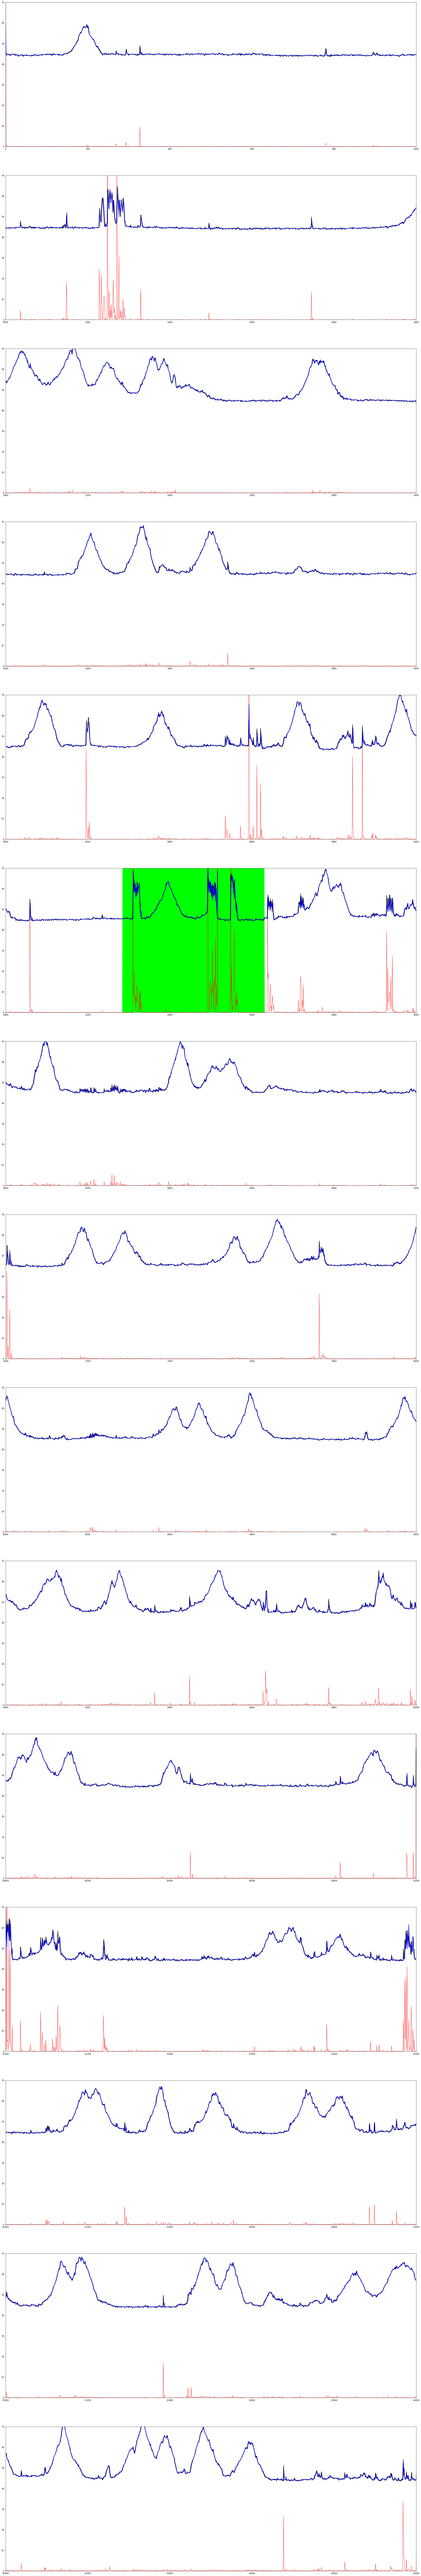

In [16]:
fig, ax=plt.subplots(num_ax, 1, figsize=(35, 15*num_ax))
data_unit=1000
for i in range(num_ax):
    ax[i].plot(abnorm, '-r',linewidth = 1 )
    ax[i].plot(test_plot, '-k',linewidth = 2)
    ax[i].plot(z_test, '-b',linewidth = 2)
    ax[i].fill_between(label_index, label, facecolor='lime' )
    ax[i].set_ylim(0, 70)
    ax[i].set_xlim(i*(data_unit), (data_unit)*(i+1))
plt.show()